# 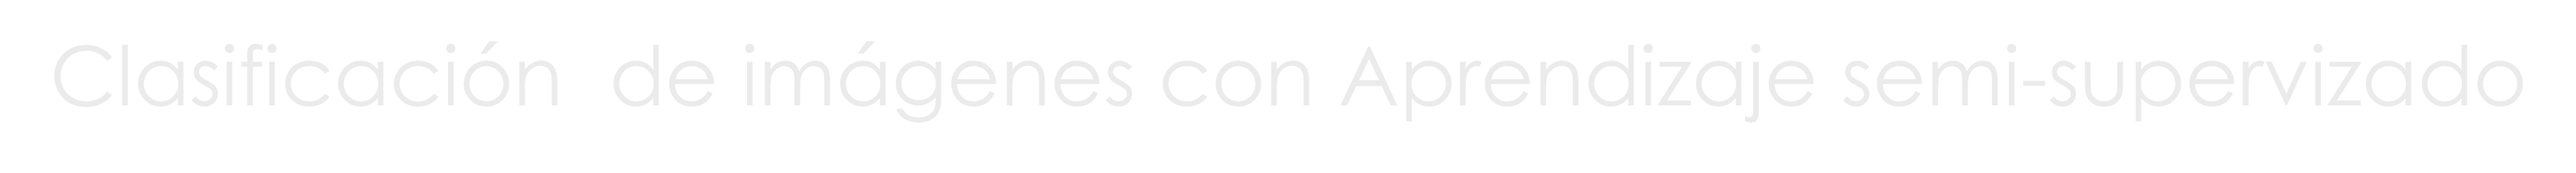

# Proyecto para curso introduccion a la Inteligencia Artificial
## Clasificacion de Imagenes con Aprendizaje semi - supervizado
1. Autor: Ivan Bozo Catalan      
2. Profesor de apoyo: Christopher Flores
3. Universidad de O'higgins



## Introduccion
* El aprendizaje semisupervisado es un problema de aprendizaje que implica un pequeño número de ejemplos etiquetados y un gran n´umero de ejemplos no etiquetados. Los problemas de aprendizaje de este tipo suponen un reto, ya que ni los algoritmos de aprendizaje supervisado ni los de aprendizaje no supervisado son capaces de hacer un uso eficaz de las mezclas de datos etiquetados y no etiquetados. Por ello, se necesitan algoritmos especializados de aprendizaje semisupervisado.
* El objetivo de este proyecto es implementar algoritmos de aprendizaje semi-supervisado, evaluando la cantidad de ejemplos de entrenamiento pseudo-etiquetados y el desempeño de los clasificadores utilizados


### Codigo y comentarios
1. Librerias necesarias para el proyecto

In [37]:
# Tensorflow es una biblioteca de código abierto desarrollada por Google Brain, utilizada para el desarrollo de modelos de aprendizaje automático.
import tensorflow as tf

# Keras es una biblioteca de alto nivel para la construcción y formación de modelos de aprendizaje profundo. 
# Proporciona una interfaz intuitiva y fácil de usar sobre Tensorflow.
from tensorflow.keras.utils import plot_model # Importando plot_model para visualizar el modelo
from keras.models import Sequential, Model  # Importando las clases Sequential y Model para la construcción de modelos
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout  # Importando varias clases de capas
from keras.layers import Conv2D, MaxPooling2D  # Importando las capas Conv2D y MaxPooling2D para modelos de Convolutional Neural Networks (CNN)
from tensorflow.keras.layers import Input  # Importando la clase Input para la creación de modelos
from tensorflow.keras.optimizers import Adam  # Importando la clase Adam, un optimizador que se usa frecuentemente en redes neuronales
from keras.utils import to_categorical  # Utilidad para convertir un vector de clase (enteros) en una matriz de clase binaria
from keras.callbacks import EarlyStopping  # Permite parar el entrenamiento cuando una métrica deja de mejorar

# Matplotlib es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.
from matplotlib import pylab  # Submódulo de matplotlib para trazar gráficos

# Bibliotecas y módulos estándar de Python para trabajar con archivos y números aleatorios
import random
import os

# SciPy es una biblioteca que contiene módulos para optimización, álgebra lineal, integración, interpolación, funciones especiales, FFT, procesamiento de señales y de imagen, ODE y más.
from scipy.stats import entropy  # Importando la función de entropía

# Scikit-learn es una biblioteca de aprendizaje automático que proporciona una selección de algoritmos de clasificación, regresión y clustering eficientes.
from sklearn.metrics import f1_score, classification_report  # Importando métricas de rendimiento de modelos

# Matplotlib es una biblioteca para la generación de gráficos a partir de datos contenidos en listas o arrays en Python y su extensión matemática NumPy.
import matplotlib.pyplot as plt

# NumPy es una biblioteca para el lenguaje de programación Python que da soporte para crear vectores y matrices grandes multidimensionales, junto con una gran colección de funciones matemáticas de alto nivel para operar con ellas.
import numpy as np

# Imprime la versión de tensorflow
print(tf.__version__)


2.11.0


In [38]:
#obtener data
mnist = tf.keras.datasets.fashion_mnist
#colocar el data en las variables para trabajar
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

In [39]:
#mirar dimensiones
training_images.shape

(60000, 28, 28)

In [40]:
test_images.shape

(10000, 28, 28)

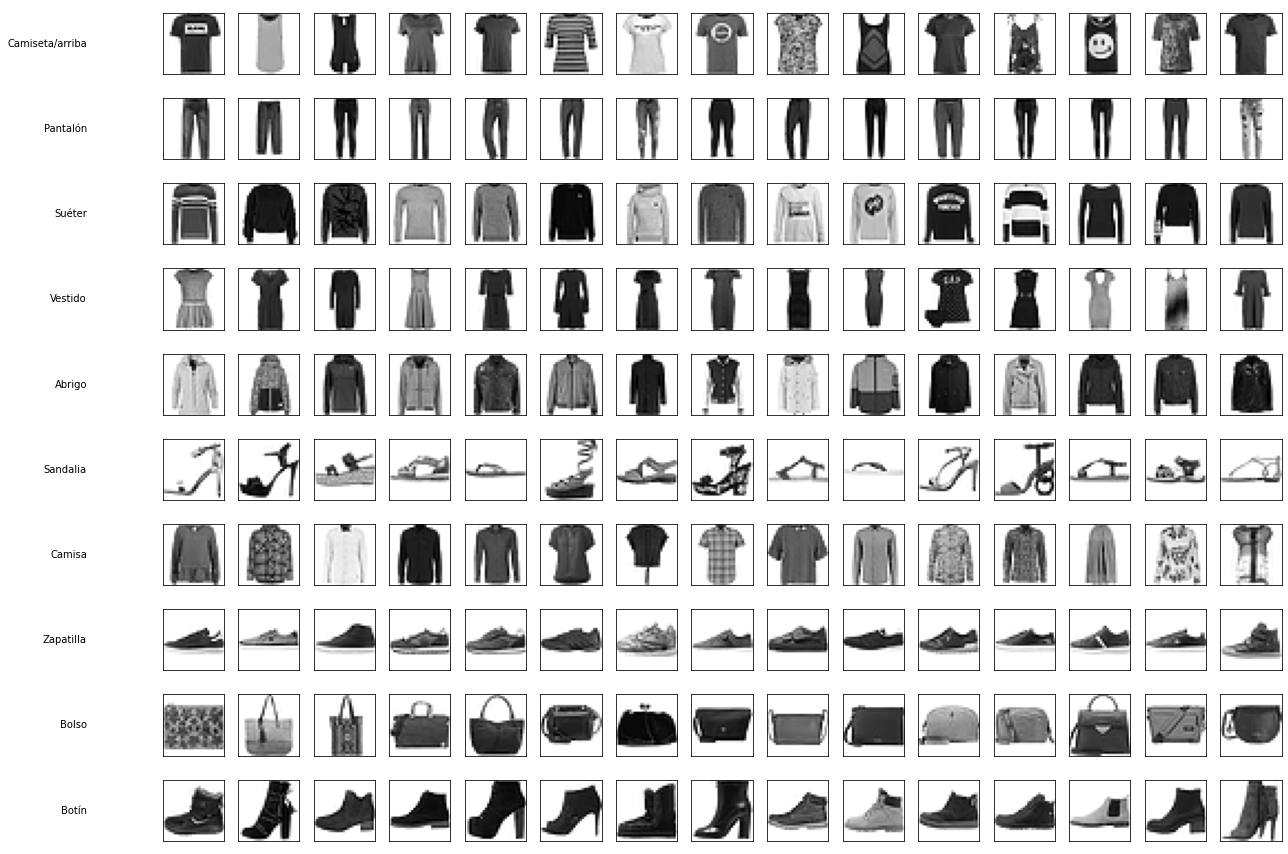

In [41]:
classes_names = ['Camiseta/arriba', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']
plt.figure(figsize=(18,12))
num_images_per_class = 15 # Número de imágenes por clase a mostrar

for c, class_name in enumerate(classes_names):  # Iterar sobre las 10 clases
    # Plot adicional para mostrar los nombres de las clases en la columna 0
    plt.subplot(10, 16, c * 16 + 1)  # La primera columna ocupa 11 posiciones
    plt.axis('off')
    plt.text(0, 0.5, class_name, fontsize=10, ha='right', va='center')
    class_images = training_images[training_labels == c]  # Filtrar las imágenes de la clase actual
    for i in range(num_images_per_class):  # Iterar sobre las primeras num_images_per_class imágenes de la clase actual
        plt.subplot(10, 16, c * 16 + i + 2)  # Calcular el índice correcto en el subplot
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(class_images[i], cmap=plt.cm.binary)
plt.tight_layout()
plt.show()


In [42]:
#Normalizamos las entradas 
training_images  = training_images / 255.0
test_images = test_images / 255.0

In [43]:
# Define la semilla que se utilizará para los generadores de números aleatorios para asegurar la reproducibilidad
semilla=42

def reproducible_results(seed):  
  """
  Esta función configura las semillas de los generadores de números aleatorios en varias bibliotecas 
  para asegurar que los experimentos sean reproducibles.
  
  :param seed: El valor de la semilla a utilizar.
  """
  
  # Configura la semilla para el generador de números aleatorios en NumPy
  np.random.seed(seed)
  
  # Configura la semilla para el generador de números aleatorios en la biblioteca estándar de Python
  random.seed(seed)
  
  # Configura la semilla para el generador de números aleatorios en el entorno Python
  # Este es un intento de hacer que las funciones de hash sean deterministas en Python
  os.environ['PYTHONHASHSEED'] = str(0)
  
  # Configura la semilla para el generador de números aleatorios en TensorFlow
  tf.compat.v1.set_random_seed(seed)


### Preparamos los datos para el enfoque semi-supervizado


In [54]:
dim1, dim2 = (28, 28)  # Dimensiones de las imágenes

#numero clases
nclasses = 10  # Número de clases en el conjunto de datos

############################
x_training = training_images
y_training = training_labels
############################

def get_data(x_training,
             y_training,
             examples_per_clase,
             nclasses=nclasses):
    """
    Función para obtener un subconjunto de datos de entrenamiento balanceado.
    :param x_training: Conjunto de datos de entrenamiento.
    :param y_training: Etiquetas correspondientes al conjunto de datos de entrenamiento.
    :param examples_per_clase: Número de ejemplos por clase que se desea obtener.
    :param nclasses: Número de clases en el conjunto de datos.
    :return: Conjunto de datos de entrenamiento original sin los ejemplos seleccionados, subconjunto de datos balanceado.
    """
    x_training = x_training.copy()
    y_training = y_training.copy()
    for i in range(nclasses):
        idx = np.where(y_training == i)[0][:examples_per_clase]
        if i == 0:
            x = x_training[idx].copy()
            y = y_training[idx].copy()
        else:
            x = np.vstack((x, x_training[idx]))
            y = np.hstack((y, y_training[idx]))
        x_training = np.delete(x_training, idx, axis=0)
        y_training = np.delete(y_training, idx, axis=0)
    return x_training, y_training, x, y

#ejemplos por clase (training)
examples_training = 2000 # Número de ejemplos POR CLASE para el conjunto de entrenamiento
x_training, y_training, xl, yl = get_data(x_training, y_training, examples_training)
print('train x:', xl.shape)  # Imprimir la forma del conjunto de entrenamiento balanceado
print('train y:', yl.shape)  # Imprimir la forma de las etiquetas correspondientes

#ejemplos por clase (validation)
examples_validation = 200  # Número de ejemplos POR CLASE para el conjunto de validación
x_training, y_training, xv, yv = get_data(x_training, y_training, examples_validation)
print('val x:', xv.shape)  # Imprimir la forma del conjunto de validación balanceado
print('val y:', yv.shape)  # Imprimir la forma de las etiquetas correspondientes

#data sin etiquetas (unlabeled)
xu = x_training.copy()  # Copiar el conjunto de datos de entrenamiento restante como datos sin etiquetas
del y_training  # Eliminar las etiquetas del conjunto de entrenamiento original
print('unlabeled x:', xu.shape)  # Imprimir la forma de los datos sin etiquetas


train x: (20000, 28, 28)
train y: (20000,)
val x: (2000, 28, 28)
val y: (2000,)
unlabeled x: (38000, 28, 28)


In [45]:
batch_size = 128  # Tamaño del lote utilizado en el entrenamiento
epochs = 12  # Número de épocas para entrenar el modelo
input_shape = (28, 28, 1)  # Forma de entrada de los datos al modelo (tamaño de la imagen)

def get_dropout(input_tensor, p=0.5, mc=False, semilla=semilla):
    """
    Función para aplicar Dropout a una capa de entrada tensor.
    :param input_tensor: Tensor de entrada.
    :param p: Probabilidad de eliminar conexiones en el Dropout.
    :param mc: Booleano para activar el Dropout estocástico Monte Carlo.
    :param semilla: Semilla para reproducibilidad.
    :return: Tensor con Dropout aplicado.
    """
    if mc:
        return Dropout(p, seed=semilla)(input_tensor, training=True)
    else:
        return Dropout(p, seed=semilla)(input_tensor)

def get_model(mc=False, act="relu", input_shape=input_shape, seed=semilla):
    """
    Función para obtener el modelo de red neuronal convolucional.
    :param mc: Booleano para activar el Dropout estocástico Monte Carlo.
    :param act: Función de activación a utilizar en las capas convolucionales y densas.
    :param input_shape: Forma de entrada de los datos al modelo.
    :param seed: Semilla para reproducibilidad.
    :return: Modelo de red neuronal convolucional compilado.
    """
    reproducible_results(seed)  # Establecer reproducibilidad de resultados
    initializer = tf.keras.initializers.GlorotUniform(seed=seed)  # Inicializador para los pesos de las capas
    inp = Input(input_shape)  # Capa de entrada del modelo
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)  # Capa convolucional 1
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)  # Capa convolucional 2
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Capa de Max Pooling
    x = get_dropout(x, p=0.25, mc=mc)  # Capa de Dropout aplicada al tensor x
    x = Flatten()(x)  # Capa de aplanamiento de la imagen en un tensor unidimensional
    x = Dense(128, activation=act, kernel_initializer=initializer)(x)  # Capa densa completamente conectada
    x = get_dropout(x, p=0.5, mc=mc)  # Capa de Dropout aplicada al tensor x
    out = Dense(10, activation='softmax', kernel_initializer=initializer)(x)  # Capa de salida con activación softmax
    
    model = Model(inputs=inp, outputs=out)  # Crear el modelo de red neuronal
    
    model.compile(loss='categorical_crossentropy',  # Compilar el modelo con función de pérdida, optimizador y métricas
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [46]:
# Obtenemos el modelo utilizando la función get_model()
# Devuelve un modelo con la función de activación "relu", y el parámetro mc activado.
model = get_model(mc=True, act="relu")

# Configuramos el early stopping para evitar el sobreajuste. Esto detendrá el entrenamiento si la pérdida en el conjunto de validación ('val_loss')
# no mejora después de 10 épocas (definido por patience=10). El modo 'min' indica que el entrenamiento se detendrá cuando 'val_loss' deje de disminuir
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)


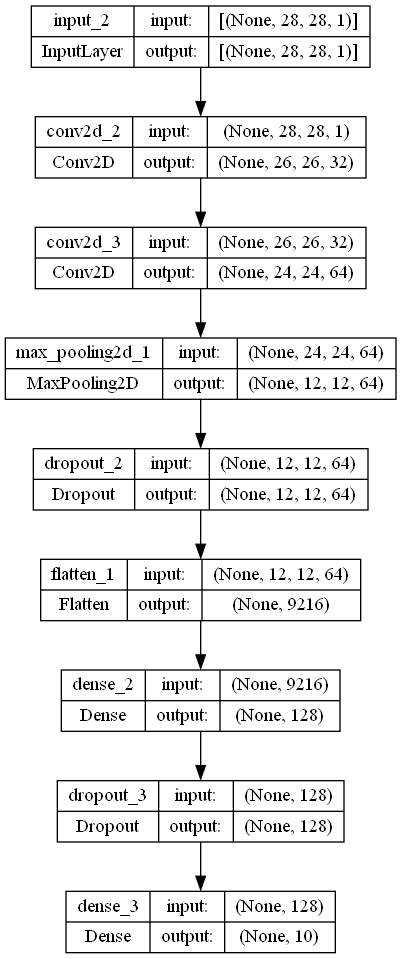

In [48]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [51]:
t=10

# Función que repite el entrenamiento varias veces
def numerode_veces(veces, t, batch, xu, xl, yl):
    L = 5
    W = 5
    fscore = []  # Lista para almacenar los puntajes F1
    cantidad_de_datos = []  # Lista para almacenar la cantidad de datos etiquetados
  
    for i in range(veces):
        print("Posicion de numero de veces", i + 1)
        print("Datos etiquetados ", xl.shape[0])
        print("Datos sin etiqueta: ", xu.shape[0])
        cantidad_de_datos.append(xl.shape[0])
        print(f"Cantidad de datos etiquetados {cantidad_de_datos}")
        
        ylcod = to_categorical(yl, 10)  # Convertir etiquetas a representación categórica
        yvcod = to_categorical(yv, 10)
        
        h = model.fit(xl, ylcod,  # Entrenar el modelo con los datos etiquetados
                      batch_size=batch_size,
                      epochs=100,
                      verbose=0,
                      validation_data=(xv, yvcod), callbacks=[es])
        
        pred = model.predict(test_images)  # Realizar predicciones en las imágenes de prueba
        pred = np.argmax(pred, axis=1)  # Convertir las predicciones a etiquetas numéricas
        f1score = 100 * f1_score(test_labels, pred, average='weighted')  # Calcular el puntaje F1
        fscore.append(f1score)  # Agregar el puntaje F1 a la lista
        
        predxuaux = []
        for i in range(t):
            predxu = model.predict(xu)  # Realizar predicciones en los datos sin etiqueta
            predxuaux.append(predxu)
        
        predxuaux = np.array(predxuaux)
        predxuaux = np.mean(predxuaux, axis=0)  # Calcular el promedio de las predicciones
        entropia = entropy(predxuaux, axis=1)  # Calcular la entropía de las predicciones
        
        idxx = np.argsort(entropia)[:batch]  # Obtener los índices de los datos con menor entropía
        ylaux = np.argmax(predxuaux, axis=1)[idxx]  # Obtener las etiquetas correspondientes
        xlaux = xu[idxx]  # Obtener los datos correspondientes
        xl = np.vstack((xl, xlaux))  # Agregar los datos etiquetados
        yl = np.hstack((yl, ylaux))  # Agregar las etiquetas
        xu = np.delete(xu, idxx, axis=0)  # Eliminar los datos etiquetados de los datos sin etiqueta
        
        print(fscore)
        print(classification_report(test_labels, pred))  # Imprimir el informe de clasificación
        
    # Mostrar gráfica de puntajes F1 vs cantidad de datos etiquetados
    fig = pylab.figure(1, figsize=(10, 10))
    pylab.plot(cantidad_de_datos, fscore, 'orange', label='score vs data training')
    pylab.legend(loc='upper left')
    pylab.show()
    
    # Mostrar visualización de las imágenes de prueba con etiquetas predichas y reales
    fig, axes = plt.subplots(L, W, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in np.arange(0, L * W):
        axes[i].imshow(test_images[i].reshape(28, 28))
        axes[i].set_title(f"CP = {classes_names[pred[i]]}\n CO = {classes_names[test_labels[i]]}")
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)


Posicion de numero de veces 1
Datos etiquetados  20000
Datos sin etiqueta:  38000
Cantidad de datos etiquetados [20000]
1188/1188 [==============================] - 8s 7ms/step
[89.62039417924116]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.87      0.90      0.88      1000
           4       0.81      0.86      0.84      1000
           5       0.97      0.98      0.97      1000
           6       0.75      0.70      0.72      1000
           7       0.95      0.95      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Posicion de numero de veces 2
Datos etiqueta

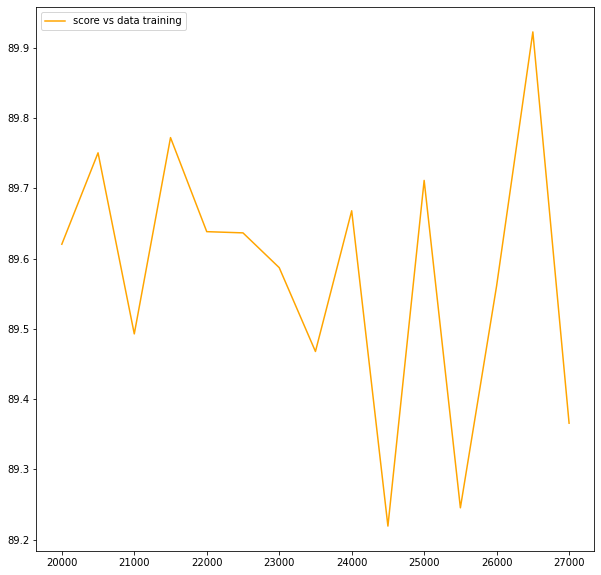

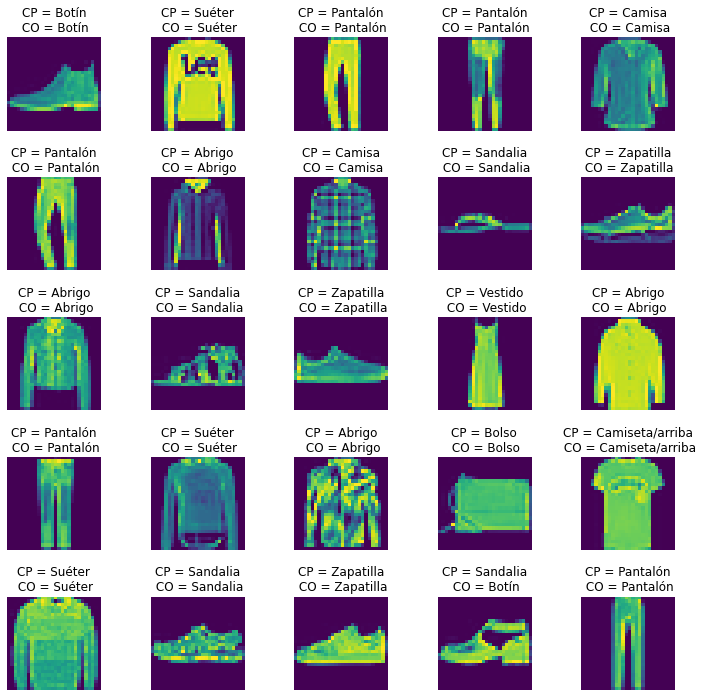

In [ ]:
batch = 500 #Datos confiables para agregar a la iteracion
numerode_veces(15,t,batch,xu,xl,yl) #15 iteraciones de 500 datos confiables 

In [ ]:
dim1, dim2 = (28, 28)  # Dimensiones de las imágenes
#numero clases
nclasses = 10  # Número de clases en el conjunto de datos

############################
x_training = training_images
y_training = training_labels
############################

def get_data(x_training,
             y_training,
             examples_per_clase,
             nclasses=nclasses):
    """
    Función para obtener un subconjunto de datos de entrenamiento balanceado.
    :param x_training: Conjunto de datos de entrenamiento.
    :param y_training: Etiquetas correspondientes al conjunto de datos de entrenamiento.
    :param examples_per_clase: Número de ejemplos por clase que se desea obtener.
    :param nclasses: Número de clases en el conjunto de datos.
    :return: Conjunto de datos de entrenamiento original sin los ejemplos seleccionados, subconjunto de datos balanceado.
    """
    x_training = x_training.copy()
    y_training = y_training.copy()
    for i in range(nclasses):
        idx = np.where(y_training == i)[0][:examples_per_clase]
        if i == 0:
            x = x_training[idx].copy()
            y = y_training[idx].copy()
        else:
            x = np.vstack((x, x_training[idx]))
            y = np.hstack((y, y_training[idx]))
        x_training = np.delete(x_training, idx, axis=0)
        y_training = np.delete(y_training, idx, axis=0)
    return x_training, y_training, x, y

#ejemplos por clase (training)
examples_training = 10 # Número de ejemplos POR CLASE para el conjunto de entrenamiento
x_training, y_training, xl, yl = get_data(x_training, y_training, examples_training)
print('train x:', xl.shape)  # Imprimir la forma del conjunto de entrenamiento balanceado
print('train y:', yl.shape)  # Imprimir la forma de las etiquetas correspondientes

#ejemplos por clase (validation)
examples_validation = 1 # Número de ejemplos POR CLASE para el conjunto de validación
x_training, y_training, xv, yv = get_data(x_training, y_training, examples_validation)
print('val x:', xv.shape)  # Imprimir la forma del conjunto de validación balanceado
print('val y:', yv.shape)  # Imprimir la forma de las etiquetas correspondientes

#data sin etiquetas (unlabeled)
xu = x_training.copy()  # Copiar el conjunto de datos de entrenamiento restante como datos sin etiquetas
del y_training  # Eliminar las etiquetas del conjunto de entrenamiento original
print('unlabeled x:', xu.shape)  # Imprimir la forma de los datos sin etiquetas

train x: (100, 28, 28)
train y: (100,)
val x: (10, 28, 28)
val y: (10,)
unlabeled x: (59890, 28, 28)


Posicion de numero de veces 1
Datos etiquetados  100
Datos sin etiqueta:  59890
Cantidad de datos etiquetados [100]
1872/1872 [==============================] - 14s 7ms/step
[90.82814557865422]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.88      0.83      0.86      1000
           3       0.93      0.90      0.91      1000
           4       0.81      0.91      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.71      0.74      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Posicion de numero de veces 2
Datos etiquetados

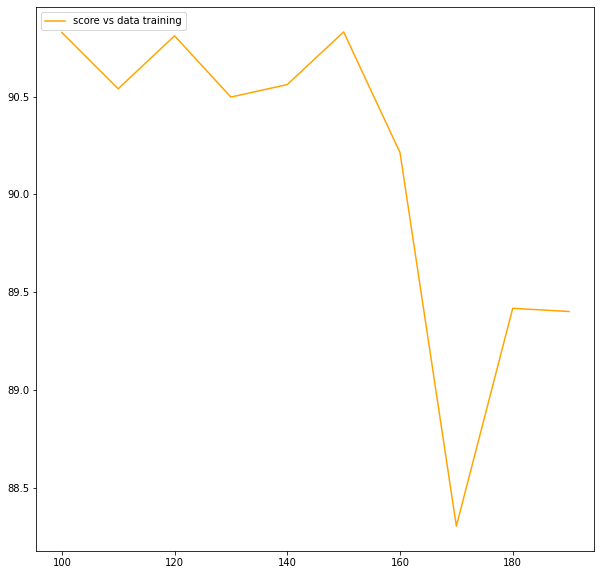

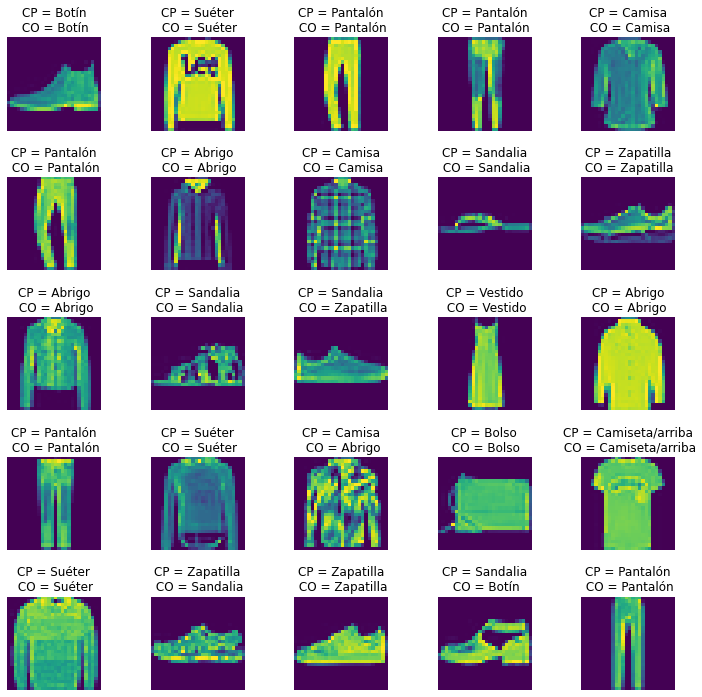

In [ ]:
####################################################
batch = 10 #10 datos confiables para agregar en cada iteracion
####################################################
numerode_veces(10,t,batch,xu,xl,yl)

Posicion de numero de veces 1
Datos etiquetados  100
Datos sin etiqueta:  59890
Cantidad de datos etiquetados [100]
1872/1872 [==============================] - 15s 8ms/step
[90.3343860205901]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.86      0.85      1000
           3       0.89      0.91      0.90      1000
           4       0.85      0.83      0.84      1000
           5       0.98      0.98      0.98      1000
           6       0.76      0.71      0.74      1000
           7       0.96      0.95      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Posicion de numero de veces 2
Datos etiquetados 

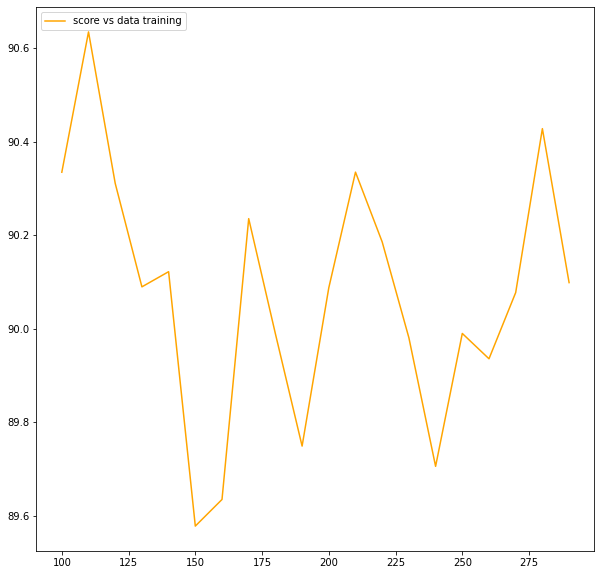

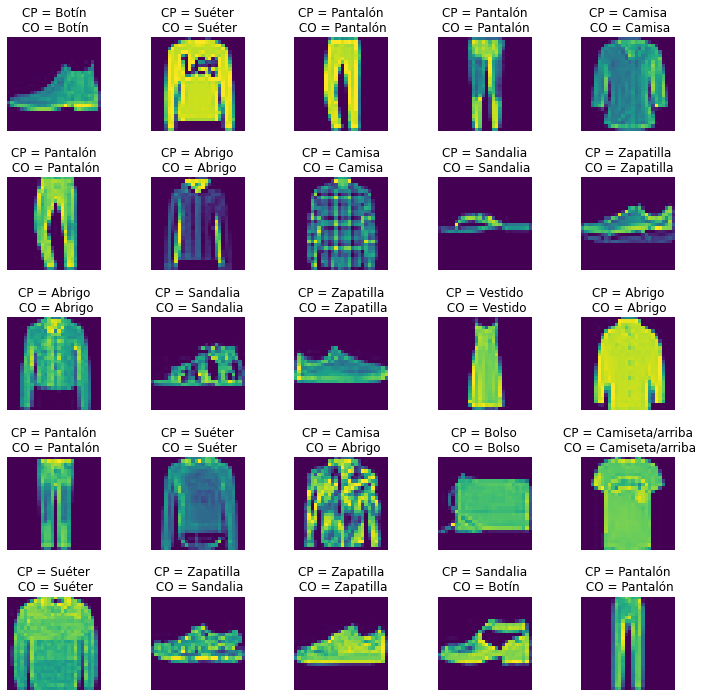

In [ ]:
numerode_veces(20,t,batch,xu,xl,yl)#20 iteraciones de agregar 10 datos confiable